# Module 8 Group 25 CNN

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

#from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import applications
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPooling2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau

import cv2
import os
import numpy as np
import math

## I. Load Data


In [3]:
imgdir = '/content/drive/MyDrive/chest_xray/'
data_gen = ImageDataGenerator(rescale=1.0/255)
img_size = 150
batch_size = 32

In [28]:
# Read the images in the training set
train_generator = data_gen.flow_from_directory(
        imgdir + '/train',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        classes=['NORMAL', 'PNEUMONIA'],
        seed=12345,
        shuffle=True)

Found 5216 images belonging to 2 classes.


In [29]:
train_x, train_y = train_generator.next()

Pneumonia


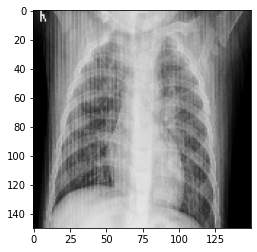

In [ ]:
plt.imshow(train_x[4], cmap = 'gray')
print('Normal') if train_y[4]== 0 else print("Pneumonia")

In [ ]:
# Read the images in the validation set
val_generator = data_gen.flow_from_directory(
        imgdir + '/val',
        target_size=(img_size, img_size),
        batch_size=1,
        class_mode='binary',
        classes=['NORMAL', 'PNEUMONIA'],
        seed=12345,
        shuffle=True)

Found 16 images belonging to 2 classes.


In [9]:
# Read the images in the test set
test_generator = data_gen.flow_from_directory(
        imgdir + '/test',
        target_size=(img_size, img_size),
        batch_size=1,
        class_mode= 'binary',
        classes=['NORMAL', 'PNEUMONIA']
        #seed=12345,
        #shuffle=True
        )

Found 624 images belonging to 2 classes.


## II. Data Augmentation

In [ ]:
train_gen = ImageDataGenerator(rescale = 1./255,
                               shear_range = 0.2,
                               zoom_range = 0.2,
                               vertical_flip = True)
val_gen = ImageDataGenerator(rescale = 1./255)

In [ ]:
train_aug = train_gen.flow_from_directory(imgdir + '/train',
                                          target_size=(img_size, img_size),
                                          batch_size=batch_size,
                                          class_mode = 'binary',
                                          classes=['NORMAL', 'PNEUMONIA'])

val_aug = val_gen.flow_from_directory(imgdir + '/val',
                                          target_size=(img_size, img_size),
                                          batch_size=batch_size,
                                          class_mode = 'binary',
                                          classes=['NORMAL', 'PNEUMONIA'])

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


## III. Define the CNN model

In [ ]:
# Assign the weight for each class
weight_for_p = (1/num_of_p) * (num_of_n + num_of_p) / 2
weight_for_n = (1/num_of_n) * (num_of_n + num_of_p) / 2
class_weights = {0: weight_for_n, 1:weight_for_p}

print('Weight for PNEUMONIA:', weight_for_p)
print('Weight for NORMAL:', weight_for_n)

Weight for PNEUMONIA: 0.6730322580645162
Weight for NORMAL: 1.9448173005219984


In [ ]:
class  CNN_Classifier(object):
  def _init_(self):
    self.model_fit = None
    self.predictions = None
    self.model = None

  # Define the model
  def model(self, img_size_width, img_size_height, channels):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=(3, 3), strides=(1,1),padding = 'same', activation= 'relu',
            input_shape = (img_size_width, img_size_height, channels)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding = 'same'))

    model.add(Conv2D(64, (3, 3), strides = 1, padding = 'same', activation='relu'))
    model.add(Dropout(0.1)) # dropout layer used to prevent overfitting
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding = 'same'))

    model.add(Conv2D(64, (3, 3), strides = 1, padding = 'same',activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding = 'same'))

    model.add(Conv2D(128, (3, 3), strides = 1, padding = 'same',activation='relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding = 'same'))

    model.add(Conv2D(256, (3, 3), strides = 1, padding = 'same', activation='relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding = 'same'))

    #model.add(Conv2D(128, (3, 3), strides = 1, padding = 'same', activation='relu'))
    #model.add(BatchNormalization())
    #model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding = 'same'))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(1, activation='sigmoid'))

    # Train the model using the Adam optimizer
    model.compile(loss='binary_crossentropy',
                optimizer='adam',
                #optimizer = "rmsprop",
                metrics=['accuracy'])
    
    # Display the architecture of model
    model.summary()

    return model

  # Fit the model
  def fit(self, train_generator, val_generator, img_size_width, img_size_height, channels):
    # Get the model
    model = self.model(img_size_width, img_size_height, channels)
    # Reduce learning rate when a metric has stopped improving
    #learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
    # Fit the model
    training_batchsize = len(train_generator)
    validation_batchsize = len(val_generator)
    epoch = 25
    model_fit = model.fit(
        train_generator,
        batch_size = batch_size,
        epochs = epoch,
        verbose = 1,
        validation_data=val_generator,
        class_weight = class_weights,
        #callbacks = [learning_rate_reduction],
        steps_per_epoch=training_batchsize, 
        validation_steps=validation_batchsize
    )
    model.save_weights("weights/cnn_weights_02")
    self.model_fit = model_fit
    self.model = model
    # Print the training and validation accuracy
    train_score = model.evaluate(train_generator, batch_size=batch_size, verbose=0)
    print('Training loss:', train_score[0])
    print('Training accuracy:', train_score[1])
    val_score = model.evaluate(val_generator, batch_size=batch_size, verbose=0)
    print('Validation loss:', val_score[0])
    print('Validation accuracy:', val_score[1])

  def predict(self, test_generator):
    cnn = self.model
    n = len(test_generator.labels)
    #probabilities = cnn.predict_generator(test_generator,steps = n)
    prob = cnn.predict(test_generator,steps = n)
    pred = prob > 0.5
    predictions = pred.astype(int)
    self.predictions = predictions
    return predictions

  def plot_loss(self):
    model_fit = self.model_fit
    # Plot the training and validation loss for each epoch
    plt.plot(model_fit.epoch, model_fit.history['loss'], color = 'red', label = 'Training')
    plt.plot(model_fit.epoch, model_fit.history['val_loss'], color = 'blue', label = 'Validation')
    plt.title('Model loss for each epoch')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
  
  def plot_accuracy(self):
    model_fit = self.model_fit
    # Plot the training and validation accuracies for each epoch
    plt.plot(model_fit.epoch, model_fit.history['accuracy'], color = 'red', label = 'Training')
    plt.plot(model_fit.epoch, model_fit.history['val_accuracy'], color = 'blue', label = 'Validation')
    plt.title('Model accuracy for each epoch')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

  def score(self, test_generator):
    predictions = self.predictions
    model = self.model
    test_y = test_generator.labels
    
    print(classification_report(test_y, predictions, target_names = ['Normal (Class 0)','Pneumonia (Class 1)']))
    
    # Confusion matrix
    cm = confusion_matrix(test_y,predictions)
    tn, fp, fn, tp = cm.ravel()

    # scores
    test_score = model.evaluate(test_generator, batch_size=1, verbose=0)
    loss = test_score[0]
    accuracy = test_score[1]
    recall = tp / (tp + fn) # sensitivity
    precision = tp/(tp + fp)
    specificity = tn / (tn + fp) # TNR
    F1 = 2*(precision*recall) / (precision + recall)

    return cm, loss, accuracy, recall, precision, specificity, F1

## IV. Train the model

In [ ]:
batch_size, img_size_width, img_size_height, channels = train_x.shape

### 4.1 Trial

In [ ]:
cnn_1 = CNN_Classifier()
batch_size, img_size_width, img_size_height, channels = train_x.shape

In [ ]:
cnn_1.fit(train_generator, val_generator, img_size_width, img_size_height, channels)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 75, 75, 64)       2

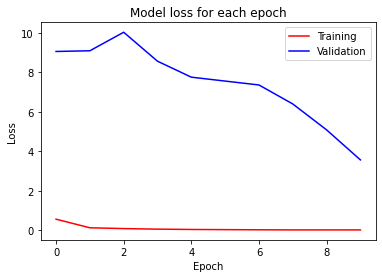

In [ ]:
cnn_1.plot_loss()

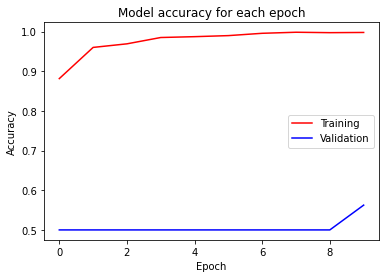

In [ ]:
cnn_1.plot_accuracy()

624/624 [==============================] - 156s 250ms/step
                     precision    recall  f1-score   support

   Normal (Class 0)       0.25      0.00      0.01       234
Pneumonia (Class 1)       0.62      0.99      0.77       390

           accuracy                           0.62       624
          macro avg       0.44      0.50      0.39       624
       weighted avg       0.48      0.62      0.48       624

Test set:
Loss: 3.3125452995300293
Accuracy: 63.141024112701416%
Sensitivity: 99.23076923076923%
Specificity: 0.4273504273504274%
Precision: 62.41935483870967%
F1 score: 76.63366336633663%


<AxesSubplot:>

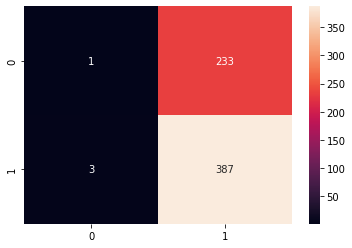

In [ ]:
pred_y = cnn_1.predict(test_generator)
# Accuracy and other score
score = cnn_1.score(test_generator)
print("Test set:")
print_score(score)
# Confusion matrix
sns.heatmap(score[0],annot=True,fmt="d")

### 4.2 With data augmentation + Weight Adjustment

In [ ]:
def print_score(score):
  print('Loss: ' + str(score[1]))
  print('Accuracy: ' + str(100*score[2]) + '%')
  print('Sensitivity: ' + str(100*score[3]) + '%')
  print('Specificity: ' + str(100*score[5]) + '%')
  print('Precision: ' + str(100*score[4]) + '%')
  print('F1 score: ' + str(100*score[6]) + '%')

#### 4.2.1: 15 epochs

In [ ]:
cnn_2 = CNN_Classifier()

In [ ]:
cnn_2.fit(train_aug, val_aug, img_size_width, img_size_height, channels)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 150, 150, 32)      896       
                                                                 
 batch_normalization_5 (Batc  (None, 150, 150, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout_4 (Dropout)         (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_6 (Batc  (None, 75, 75, 64)      

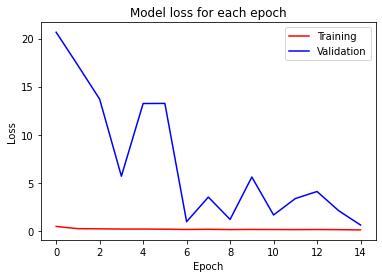

In [ ]:
cnn_2.plot_loss()

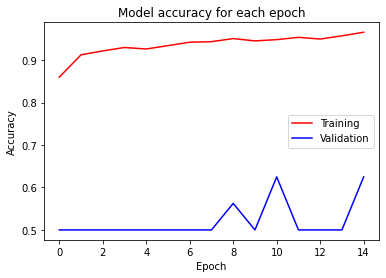

In [ ]:
cnn_2.plot_accuracy()

624/624 [==============================] - 38s 59ms/step
                     precision    recall  f1-score   support

   Normal (Class 0)       0.37      0.46      0.41       234
Pneumonia (Class 1)       0.62      0.53      0.57       390

           accuracy                           0.50       624
          macro avg       0.50      0.49      0.49       624
       weighted avg       0.53      0.50      0.51       624

Test set:
Loss: 0.40746888518333435
Accuracy: 84.61538553237915%
Sensitivity: 52.820512820512825%
Specificity: 46.15384615384615%
Precision: 62.048192771084345%
F1 score: 57.06371191135734%


<AxesSubplot:>

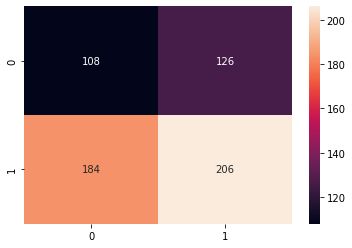

In [ ]:
pred_y_2 = cnn_2.predict(test_generator)
# Accuracy and other score
score_2 = cnn_2.score(test_generator)
print("Test set:")
print_score(score_2)
# Confusion matrix
sns.heatmap(score_2[0],annot=True,fmt="d")

#### 4.2.2: 25 epochs

In [ ]:
cnn_3 = CNN_Classifier()

In [ ]:
cnn_3.fit(train_aug, val_aug, img_size_width, img_size_height, channels)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 75, 75, 64)       2

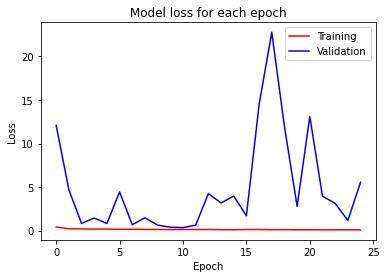

In [ ]:
cnn_3.plot_loss()

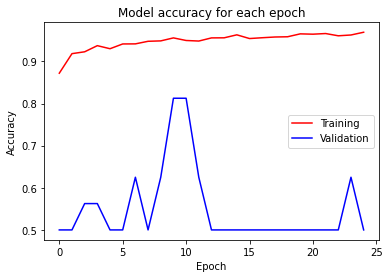

In [ ]:
cnn_3.plot_accuracy()

624/624 [==============================] - 135s 216ms/step
                     precision    recall  f1-score   support

   Normal (Class 0)       0.31      0.02      0.03       234
Pneumonia (Class 1)       0.62      0.98      0.76       390

           accuracy                           0.62       624
          macro avg       0.47      0.50      0.40       624
       weighted avg       0.51      0.62      0.49       624

Test set:
Loss: 2.5108654499053955
Accuracy: 64.58333134651184%
Sensitivity: 97.6923076923077%
Specificity: 1.7094017094017095%
Precision: 62.35679214402619%
F1 score: 76.12387612387612%


<AxesSubplot:>

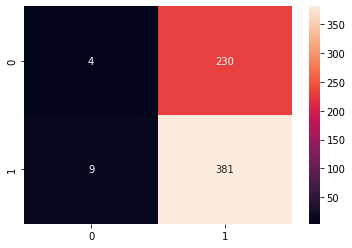

In [ ]:
pred_y_4 = cnn_3.predict(test_generator)
# Accuracy and other score
score_4 = cnn_3.score(test_generator)
print("Test set:")
print_score(score_4)
# Confusion matrix
sns.heatmap(score_4[0],annot=True,fmt="d")

#### 4.2.3: 50 epochs

In [ ]:
cnn_2.fit(train_aug, val_aug, img_size_width, img_size_height, channels)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 150, 150, 32)      896       
                                                                 
 batch_normalization_10 (Bat  (None, 150, 150, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 dropout_8 (Dropout)         (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_11 (Bat  (None, 75, 75, 64)      

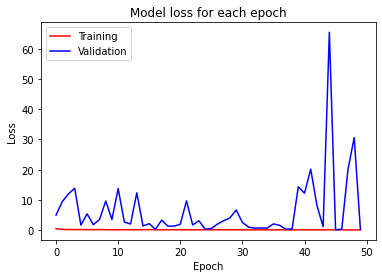

In [ ]:
cnn_2.plot_loss()

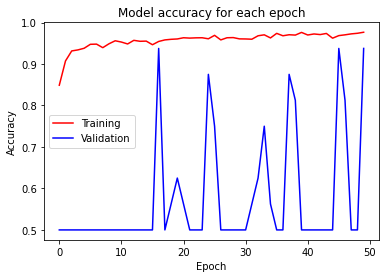

In [ ]:
cnn_2.plot_accuracy()

624/624 [==============================] - 21s 33ms/step
                     precision    recall  f1-score   support

   Normal (Class 0)       0.36      0.29      0.32       234
Pneumonia (Class 1)       0.62      0.69      0.65       390

           accuracy                           0.54       624
          macro avg       0.49      0.49      0.49       624
       weighted avg       0.52      0.54      0.53       624

Test set:
Loss: 0.6615744233131409
Accuracy: 90.70512652397156%
Sensitivity: 68.71794871794872%
Specificity: 29.059829059829063%
Precision: 61.75115207373272%
F1 score: 65.04854368932038%


<AxesSubplot:>

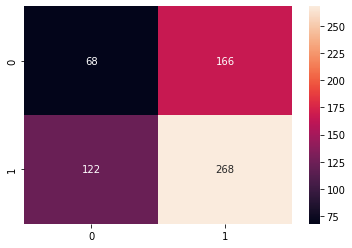

In [ ]:
pred_y_3 = cnn_2.predict(test_generator)
# Accuracy and other score
score_3 = cnn_2.score(test_generator)
print("Test set:")
print_score(score_3)
# Confusion matrix
sns.heatmap(score_3[0],annot=True,fmt="d")